In [1]:
import matplotlib.pyplot as plt
import numpy as np
from hepmc import *

In [2]:
# A more complicated test function
k = 16
tf_b = 1/.2**2
def osc(x):
    return x**2*np.cos(k*np.pi*x/.2)**2*tf_b
def dosc(x):
    return (2*x*np.cos(k*np.pi*x/.2)**2 - x**2*k*np.pi/.2*2*np.cos(k*np.pi*x/.2)*np.sin(k*np.pi*x/.2))*tf_b
def bound(a, x, b):
    return (x>a)*(x<=b)
def fn(x):
    return bound(.2, x, .4)*osc(x-.2) + bound(.4, x, .6) + bound(.6, x, .8)*osc(.8-x)
osc_integral = 1/30 + ((1.59155e-2 * k**2 - 8.06288e-4)*np.sin(6.28319*k) + 5.06606e-3*k*np.cos(6.28319*k)) / k**3
fn_true_value = 2*osc_integral + .2

def dfn(x):
    return bound(.2, x, .4)*dosc(x-.2) - bound(.6, x, .8)*dosc(.8-x)
def dpot_dq(x):
    return - dfn(x) / fn(x)

pdf = lambda x: fn(x)/fn_true_value

In [3]:
# hamilton monte carlo
pot = lambda q: -np.log(fn(q))
target = Density.make(pdf, 1, pdf_gradient=dfn)
p_dist = densities.Gaussian(1, scale=1)
hmcm = hamiltonian.HamiltonianUpdate(target, p_dist, steps=10, step_size=.01)
metrop = DefaultMetropolis(1, fn, Proposal.make(lambda _: np.random.rand(), 1))

In [4]:
size = 10000
bins = 1000
sample_met = metrop.sample(size, .5, log_every=5000)
sample_hmc = hmcm.sample(size, .5, log_every=1000)

Generated 5000 samples.
Generated 10000 samples.


/home/mathis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in cos
  """
/home/mathis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in cos
  import sys
/home/mathis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sin
  import sys


Generated 1000 samples.
Generated 2000 samples.
Generated 3000 samples.
Generated 4000 samples.
Generated 5000 samples.
Generated 6000 samples.
Generated 7000 samples.
Generated 8000 samples.
Generated 9000 samples.
Generated 10000 samples.


Metrop acceptance rate: 0.2925, Hamilton acceptance rate: 0.6206
Metrop chi2: 4.6270, Hamiltonian chi2: 5.9191


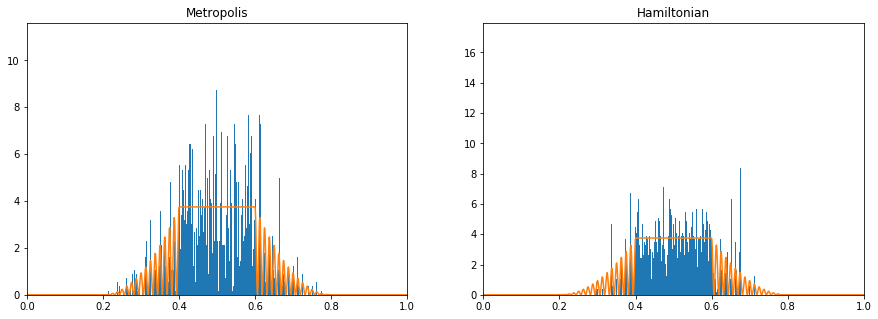

In [5]:
print("Metrop acceptance rate: %.4f, Hamilton acceptance rate: %.4f" % (sample_met.accept_ratio, sample_hmc.accept_ratio))
met_chi = util.binwise_chi2(pdf, sample_met.data, bins=bins)
hmcm_chi = util.binwise_chi2(pdf, sample_hmc.data, bins=bins)
print("Metrop chi2: %.4f, Hamiltonian chi2: %.4f" % (met_chi, hmcm_chi))


x = np.linspace(0, 1, 1000)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Metropolis")
plt.hist(sample_met.data, bins=bins, normed=True)
plt.plot(x, pdf(x))
plt.xlim(0, 1)


plt.subplot(122)
plt.title("Hamiltonian")
plt.hist(sample_hmc.data, bins=bins, normed=True)
plt.plot(x, pdf(x))
plt.xlim(0, 1)
plt.show()

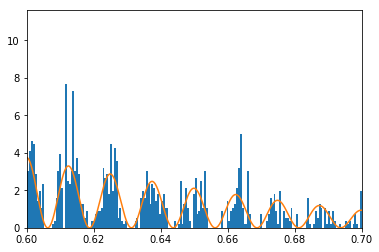

In [7]:
x = np.linspace(0.6, 0.7, 800)
plt.hist(sample_met.data, bins=1000, normed=True)
plt.plot(x, pdf(x))
plt.xlim(0.6, 0.7)
plt.show()

In [8]:
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling3 = AcceptRejectSampler(p3, 3.5)
dist3 = Distribution.make(p3, 1, rvs=lambda count: sampling3.sample(count).data)

In [9]:
mc3_u = mc3.MC3Uniform(fn, MultiChannel([dist3]), delta=.01, beta=1)

sample_mc3 = mc3_u(([], [500]*40, []), 30000, initial=.5)

Generated 5000 samples.
Generated 10000 samples.
Generated 15000 samples.
Generated 20000 samples.
Generated 25000 samples.
Generated 30000 samples.


chi^2: 1.3840281528771456


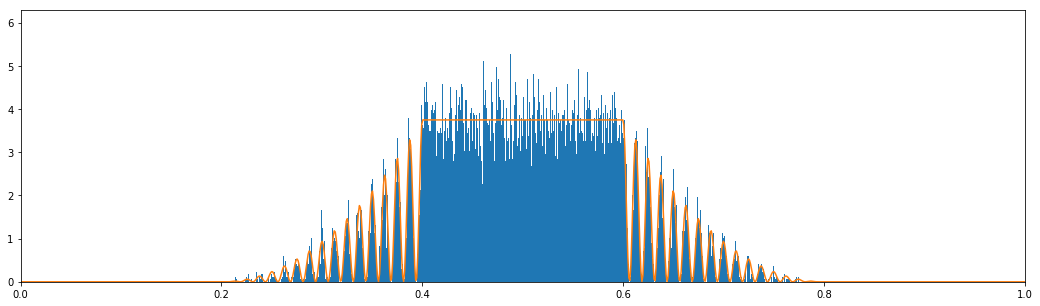

In [10]:
bins = 1000
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(18, 5))
plt.hist(sample_mc3.data, bins=bins, normed=True)
plt.plot(x, pdf(x))
plt.xlim(0, 1)
print("chi^2: " + str(util.binwise_chi2(pdf, sample_mc3.data, bins=bins)))
plt.show()

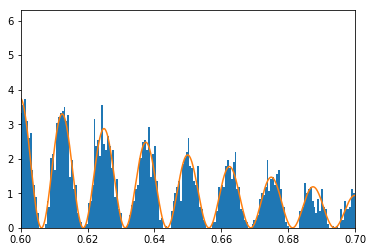

In [11]:
x = np.linspace(0.6, 0.7, 800)
plt.hist(sample_mc3.data, bins=1000, normed=True)
plt.plot(x, pdf(x))
plt.xlim(0.6, 0.7)
plt.show()

In [12]:
target = Density.make(fn, 1, pdf_gradient=dpot_dq)
mc3h = mc3.MC3Hamilton(target, MultiChannel([dist3]), np.ones(1)*100, step_size=.001, steps=10)
mc3h.beta = .9
mc3h_q = mc3h(([], [500]*40, []), 30000)

print("chi^2: " + str(util.binwise_chi2(pdf, mc3h_q.data, bins=bins)))

Generated 5000 samples.
Generated 10000 samples.
Generated 15000 samples.
Generated 20000 samples.
Generated 25000 samples.
Generated 30000 samples.
chi^2: 1.44947747750044


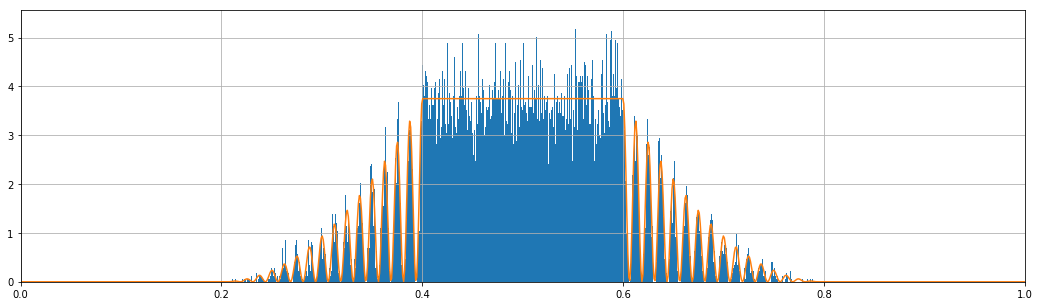

In [13]:
bins = 1000
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(18, 5))
plt.hist(mc3h_q.data, bins=bins, normed=True)
plt.plot(x, pdf(x))
plt.xlim(0, 1)
plt.grid()
plt.show()

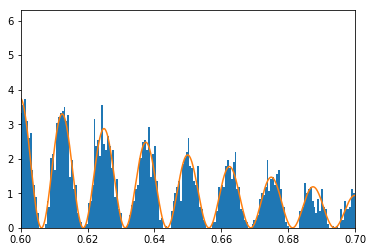

In [14]:
x = np.linspace(0.6, 0.7, 800)
plt.hist(sample_mc3.data, bins=1000, normed=True)
plt.plot(x, pdf(x))
plt.xlim(0.6, 0.7)
plt.show()